## Aditya Manjunatha

In [1]:
import kagglehub
ichhadhari_indian_birds_path = kagglehub.dataset_download('ichhadhari/indian-birds')

print('Data source import complete.')

/home/maditya/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Data source import complete.


In [2]:
!apt install torchviz
!pip install torchviz

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?
Defaulting to user installation because normal site-packages is not writeable


In [3]:
# Importing torch packages
import torch
import torch.nn as nn
import torch.nn.functional as F#All activation functions are present here
import torch.optim as optim # Optimizer is stored here
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchsummary import summary
import torchvision.models as models
from torchviz import make_dot  #visualize computational graph
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Importing other packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import csv
import os
from PIL import Image

### Using GPU

In [4]:
# To test whether GPU instance is present in the system or not.
use_cuda = torch.cuda.is_available()
print('Using PyTorch version:', torch.__version__, 'CUDA:', use_cuda)

device = torch.device("cuda" if use_cuda else "cpu")
print(device)

Using PyTorch version: 2.5.1+cu124 CUDA: True
cuda


### Creating the Dataset

In [5]:
dataset = {
    "train_data": os.path.join(ichhadhari_indian_birds_path, 'Birds_25', 'train'),
    "valid_data": os.path.join(ichhadhari_indian_birds_path, 'Birds_25', 'valid'),
}

all_data = []
for path in dataset.values():
    data = {"imgpath": [] , "labels": [] }
    category = os.listdir(path)

    for folder in category:
        folderpath = os.path.join(path , folder)
        filelist = os.listdir(folderpath)
        for file in filelist:
            fpath = os.path.join(folderpath, file)
            data["imgpath"].append(fpath)
            data["labels"].append(folder)


    all_data.append(data.copy())
    data.clear()



train_df = pd.DataFrame(all_data[0] , index=range(len(all_data[0]['imgpath'])))
valid_df = pd.DataFrame(all_data[1] , index=range(len(all_data[1]['imgpath'])))


#Convert labels to numbers
lb = LabelEncoder()
train_df['encoded_labels'] = lb.fit_transform(train_df['labels'])
valid_df['encoded_labels'] = lb.fit_transform(valid_df['labels'])

valid_df , test_df = train_test_split(valid_df ,  train_size= 0.50 , shuffle=True, random_state=124)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print(f"Size of train df {len(train_df)}")
print(f"Size of valid df {len(valid_df)}")
print(f"Size of test df {len(test_df)}")


Size of train df 30000
Size of valid df 3750
Size of test df 3750


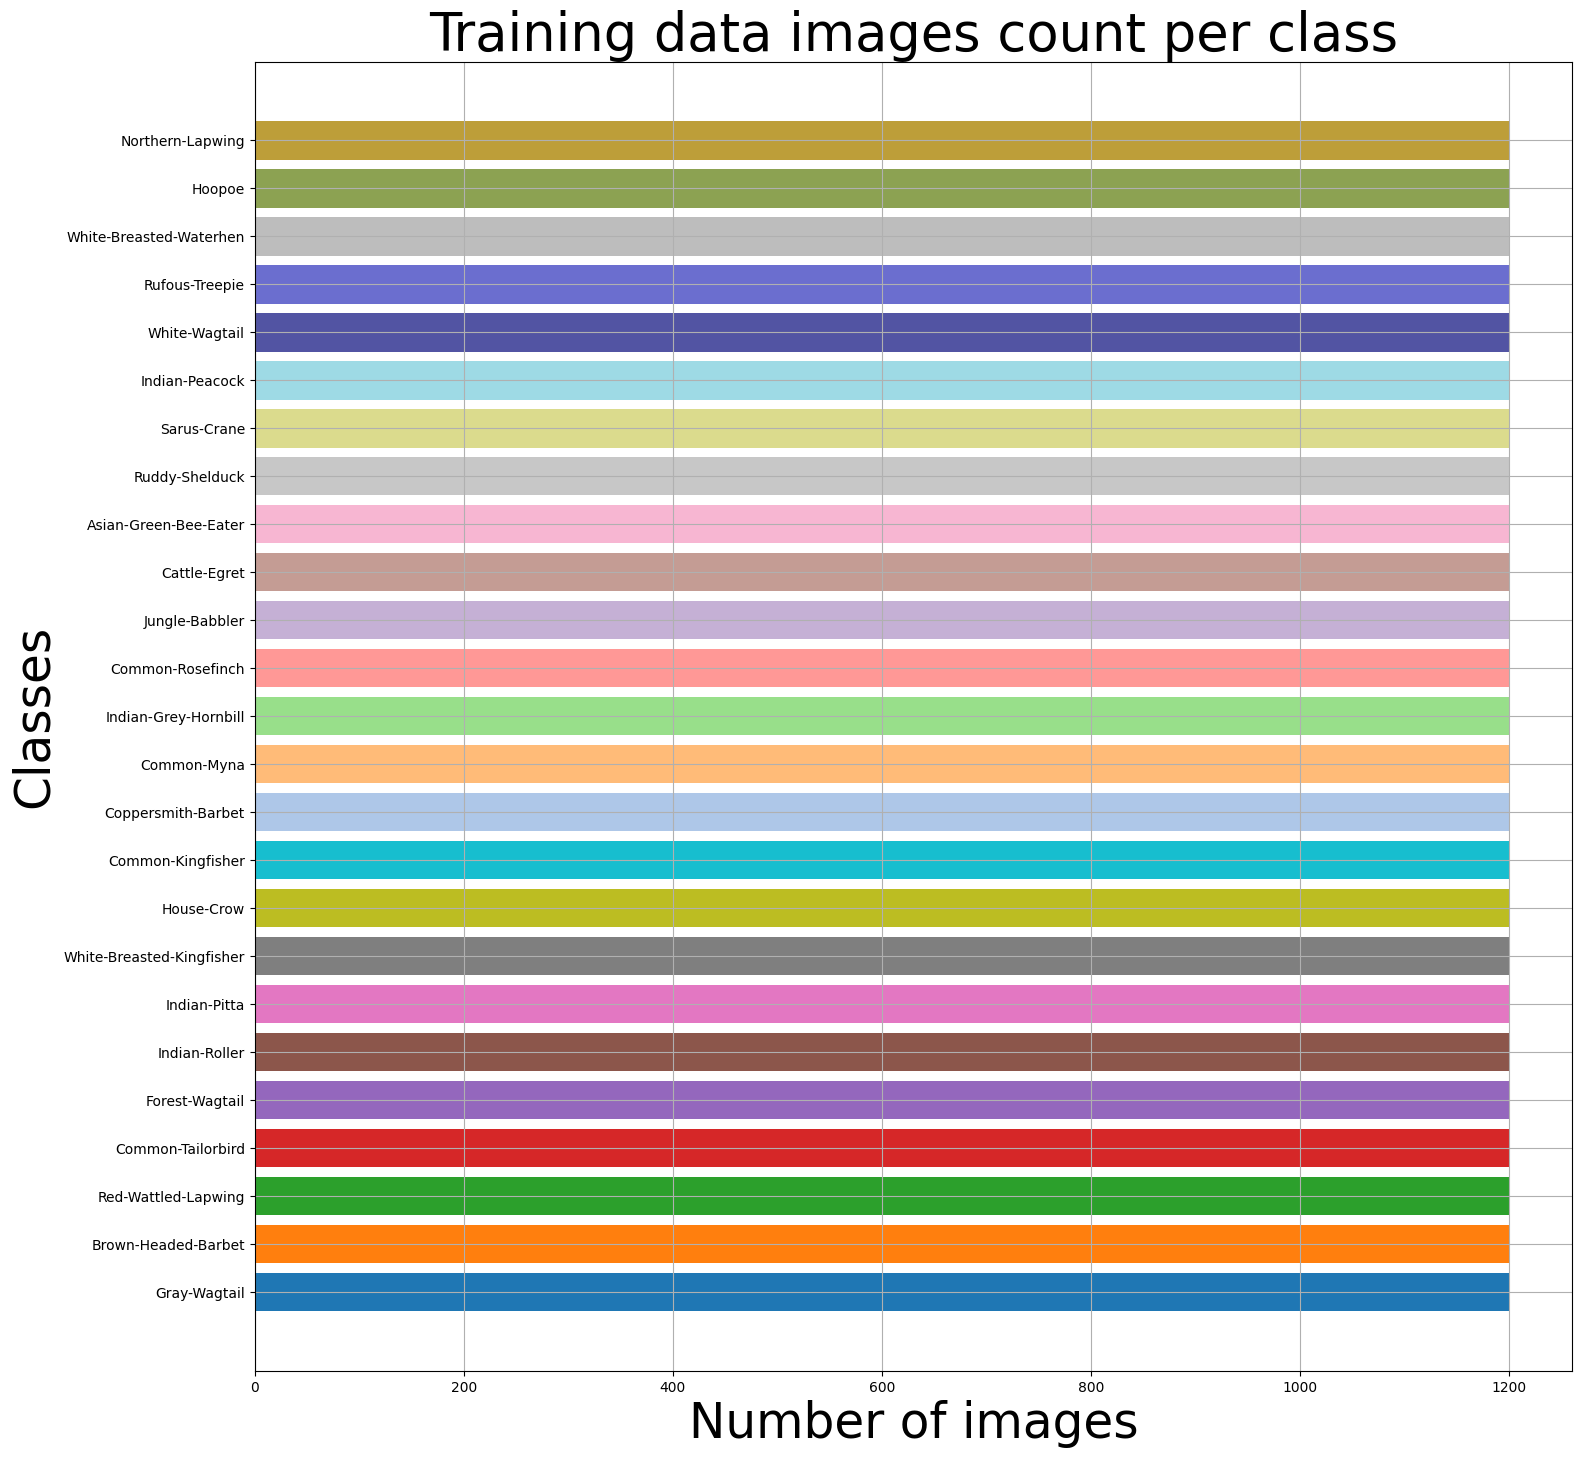

In [6]:
train  = train_df["labels"].value_counts()
label = train.tolist()
index = train.index.tolist()

colors = [
    "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd",
    "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf",
    "#aec7e8", "#ffbb78", "#98df8a", "#ff9896", "#c5b0d5",
    "#c49c94", "#f7b6d2", "#c7c7c7", "#dbdb8d", "#9edae5",
    "#5254a3", "#6b6ecf", "#bdbdbd", "#8ca252", "#bd9e39",
    "#ad494a", "#8c6d31", "#6b6ecf", "#e7ba52", "#ce6dbd",
    "#9c9ede", "#cedb9c", "#de9ed6", "#ad494a", "#d6616b",
    "#f7f7f7", "#7b4173", "#a55194", "#ce6dbd"
]



plt.figure(figsize=(17,17))
plt.title("Training data images count per class",fontsize=38)
plt.xlabel('Number of images', fontsize=35)
plt.ylabel('Classes', fontsize=35)
plt.barh(index,label, color=colors)
plt.grid(True)
plt.show()

In [ ]:
plt.figure(figsize=(15,12))
for i, row in valid_df.sample(n=16).reset_index().iterrows():
    plt.subplot(4,4,i+1)
    image_path = row['imgpath']
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(row["labels"])
    plt.axis('off')
plt.show()

In [7]:
#batch_size = 32
#image_size = (224, 224)
BATCH_SIZE = 8
IMAGE_SIZE = (224, 224)

class CustomDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.loc[idx, 'imgpath']
        image = Image.open(img_path).convert('RGB')
        label = self.df.loc[idx, 'encoded_labels']
        if self.transform:
            image = self.transform(image)
        return image, label

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),               # Random horizontal flip
    transforms.RandomRotation(10),                   # Random rotation up to 10 degrees
    transforms.RandomResizedCrop(224, scale=(0.9, 1.0)),  # Random zoom
    transforms.ColorJitter(contrast=0.1),            # Random contrast adjustment
    transforms.ToTensor(),                           # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalization
])

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = CustomDataset(train_df, transform=train_transform)
valid_dataset = CustomDataset(valid_df, transform=transform)
test_dataset = CustomDataset(test_df, transform=transform)
print(f"Train dataset size: {len(train_dataset)}")
print(f"Valid dataset size: {len(valid_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 30000
Valid dataset size: 3750
Test dataset size: 3750


### Preparing Data Loaders

In [8]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
#print(model)

### Sanity check if loaders work

In [9]:
for images, labels in train_loader:
    print("Images batch shape:", images.shape)
    print("Labels batch shape:", labels.shape)
    #print("Labels batch values:", labels)
    #print("Images[0]", images[0])
    #print("Labels[0]", labels[0])
    break  # Just print for one batch

for images, labels in valid_loader:
    print("Images batch shape:", images.shape)
    print("Labels batch shape:", labels.shape)
    break


for images, labels in test_loader:
    print("Images batch shape:", images.shape)
    print("Labels batch shape:", labels.shape)
    break


Images batch shape: torch.Size([8, 3, 224, 224])
Labels batch shape: torch.Size([8])
Images batch shape: torch.Size([8, 3, 224, 224])
Labels batch shape: torch.Size([8])
Images batch shape: torch.Size([8, 3, 224, 224])
Labels batch shape: torch.Size([8])


## Transfer Learning :- Only training the FC layer

In [ ]:
model = models.efficientnet_b3(pretrained=True)
#model = models.resnet50(pretrained=True)
#model = models.denseNet121(pretrained=True)
#model = models.mobilenet_v2(pretrained=True)
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, 25)

for param in model.parameters():
    param.requires_grad = False

# Unfreeze oly the classifier head
for param in model.classifier[1].parameters():
    param.requires_grad = True

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier[1].parameters(), lr=0.001)

train_losses = []
valid_losses = []
train_acc = []
valid_acc = []
best_valid_loss = float('inf')

### Training and Validating :- Transfer Learning

In [ ]:
num_epochs = 1
BATCH_SIZE = batch_size = 50
lr = 0.001

from tqdm import tqdm
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    model.train()
    running_train_loss = 0.0
    running_val_loss = 0.0
    correct_train = 0
    total_train = 0
    correct_val = 0
    total_val = 0

    for images, labels in tqdm(train_loader, desc = "Training", leave = False):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    model.eval()
    with torch.no_grad():
        for images, labels in tqdm(valid_loader, desc = "Validating", leave = False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    epoch_train_loss = running_train_loss / len(train_loader)
    epoch_val_loss = running_val_loss / len(valid_loader)
    train_losses.append(epoch_train_loss)
    valid_losses.append(epoch_val_loss)

    epoch_train_acc = correct_train / total_train
    epoch_val_acc = correct_val / total_val
    train_acc.append(epoch_train_acc)
    valid_acc.append(epoch_val_acc)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}, Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}')

    if epoch_val_loss < best_valid_loss:
        best_valid_loss = epoch_val_loss
        #torch.save(model.state_dict(), 'best_model_TL.pth')
        print(f"Model weights saved for epoch {epoch + 1} with validation loss: {best_valid_loss:.4f}")

    # Clear CUDA cache
    torch.cuda.empty_cache()

print(f"Batch size: {BATCH_SIZE}, Learning rate: {lr}, Number of epochs: {num_epochs}")
print(f"Best training accuracy: {max(train_acc):.2f}%")
print(f"Best validation accuracy: {max(valid_acc):.2f}%")
print("Plots for current hyperparameter combination:")
epochs_range = range(1, num_epochs + 1)
plt.figure(figsize=(8, 6))
# Plot loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, valid_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_acc, label='Train Accuracy')
plt.plot(epochs_range, valid_acc, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

## Finetuning :- Unfreeze last 2 blocks and FC layer (TL init)

In [ ]:
model = models.efficientnet_b3(pretrained=True)
#model = models.resnet50(pretrained=True)
#model = models.denseNet121(pretrained=True)
#model = models.mobilenet_v2(pretrained=True)
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, 25)
# Load the model weights
model_weights_path = 'best_model_TL.pth'
model.load_state_dict(torch.load(model_weights_path))
model.to(device)

# Unfreeze the classifier head and the last two blocks (for example)
for param in model.parameters():
    param.requires_grad = False  # Freeze all parameters first

for name, child in model.named_children():
    if name == 'features':  # "features" contains the main layers
        for layer_name, layer in list(child.named_children())[-2:]:  # Unfreeze last two blocks
            for param in layer.parameters():
                param.requires_grad = True

for param in model.classifier[1].parameters():  # Unfreeze the classifier head
    param.requires_grad = True

lr = 0.00001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

### Training and Validating

In [ ]:
num_epochs = 1
BATCH_SIZE = batch_size = 50
lr = 0.00001

from tqdm import tqdm

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    model.train()
    running_train_loss = 0.0
    running_val_loss = 0.0
    correct_train = 0
    total_train = 0
    correct_val = 0
    total_val = 0

    for images, labels in tqdm(train_loader, desc = "Training", leave = True):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    model.eval()
    with torch.no_grad():
        for images, labels in tqdm(valid_loader, desc = "Validating", leave = True):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    epoch_train_loss = running_train_loss / len(train_loader)
    epoch_val_loss = running_val_loss / len(valid_loader)
    train_losses.append(epoch_train_loss)
    valid_losses.append(epoch_val_loss)

    epoch_train_acc = correct_train / total_train
    epoch_val_acc = correct_val / total_val
    train_acc.append(epoch_train_acc)
    valid_acc.append(epoch_val_acc)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}, Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}')

    if epoch_val_loss < best_valid_loss:
        best_valid_loss = epoch_val_loss
        #torch.save(model.state_dict(), 'best_model_FT_Last2Layer.pth')
        print(f"Model weights saved for epoch {epoch + 1} with validation loss: {best_valid_loss:.4f}")

    # Clear CUDA cache
    torch.cuda.empty_cache()

print(f"Batch size: {BATCH_SIZE}, Learning rate: {lr}, Number of epochs: {num_epochs}")
print(f"Best training accuracy: {max(train_acc):.2f}%")
print(f"Best validation accuracy: {max(valid_acc):.2f}%")
print("Plots for current hyperparameter combination:")
epochs_range = range(1, num_epochs + 1)
plt.figure(figsize=(8, 6))
# Plot loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, valid_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_acc, label='Train Accuracy')
plt.plot(epochs_range, valid_acc, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()
plt.tight_layout()
plt.show()



## Train all layers of EfficientNetB3 except batch norm (other models commented out)

In [ ]:
# Load the pretrained EfficientNetB3 model
model = models.efficientnet_b3(pretrained=True)
#model = models.resnet50(pretrained=True)
#model = models.denseNet121(pretrained=True)
#model = models.mobilenet_v2(pretrained=True)
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, 25)
model = model.to(device)

# Set BatchNorm layers as non-trainable for fine-tuning
for param in model.parameters():
    param.requires_grad = True

for module in model.modules():
    if isinstance(module, nn.BatchNorm2d):
        module.eval()  # Set to evaluation mode
        for param in module.parameters():
            param.requires_grad = False


lr = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

train_losses = []
valid_losses = []
train_acc = []
valid_acc = []
best_valid_loss = float('inf')

num_epochs = 10

print(f"Batch size: {BATCH_SIZE}, Learning rate: {lr}, Number of epochs: {num_epochs}")

### Training and Validating

In [ ]:
num_epochs = 1
BATCH_SIZE = batch_size = 8
lr = 0.001

from tqdm import tqdm

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    model.train()
    running_train_loss = 0.0
    running_val_loss = 0.0
    correct_train = 0
    total_train = 0
    correct_val = 0
    total_val = 0

    for images, labels in tqdm(train_loader, desc = "Training", leave = True):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    model.eval()
    with torch.no_grad():
        for images, labels in tqdm(valid_loader, desc = "Validating", leave = True):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    epoch_train_loss = running_train_loss / len(train_loader)
    epoch_val_loss = running_val_loss / len(valid_loader)
    train_losses.append(epoch_train_loss)
    valid_losses.append(epoch_val_loss)

    epoch_train_acc = correct_train / total_train
    epoch_val_acc = correct_val / total_val
    train_acc.append(epoch_train_acc)
    valid_acc.append(epoch_val_acc)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}, Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}')

    if epoch_val_loss < best_valid_loss:
        best_valid_loss = epoch_val_loss
        torch.save(model.state_dict(), 'best_model_FT.pth')
        print(f"Model weights saved for epoch {epoch + 1} with validation loss: {best_valid_loss:.4f}")

    # Clear CUDA cache
    torch.cuda.empty_cache()

print(f"Batch size: {BATCH_SIZE}, Learning rate: {lr}, Number of epochs: {num_epochs}")
print(f"Best training accuracy: {max(train_acc):.2f}%")
print(f"Best validation accuracy: {max(valid_acc):.2f}%")
print("Plots for current hyperparameter combination:")
epochs_range = range(1, num_epochs + 1)
plt.figure(figsize=(8, 6))
# Plot loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, valid_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_acc, label='Train Accuracy')
plt.plot(epochs_range, valid_acc, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()
plt.tight_layout()
plt.show()


## Reconstructing the model from the best weights

In [ ]:
model = models.efficientnet_b3(pretrained=True)
#model = models.resnet50(pretrained=True)
#model = models.denseNet121(pretrained=True)
#model = models.mobilenet_v2(pretrained=True)
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, 25)
# Load the model weights
model_weights_path = 'best_model.pth'
model.load_state_dict(torch.load(model_weights_path))
model.to(device)

## Evaluating the models on the Test set


*   TL model
*   FT last blocks unfreezed with FC (TL model init)
*   FT every layer except batch norm





## Train all layers of DenseNet121 except the batch norm layers

In [12]:
model = models.densenet121(pretrained=True)
num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, 25)
model = model.to(device)

# Set BatchNorm layers as non-trainable for fine-tuning
for param in model.parameters():
    param.requires_grad = True

for module in model.modules():
    if isinstance(module, nn.BatchNorm2d):
        module.eval()  # Set to evaluation mode
        for param in module.parameters():
            param.requires_grad = False


lr = 0.001
num_epochs = 10
BATCH_SIZE = batch_size = 8
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

train_losses = []
valid_losses = []
train_acc = []
valid_acc = []
best_valid_loss = float('inf')

print(f"Batch size: {BATCH_SIZE}, Learning rate: {lr}, Number of epochs: {num_epochs}")

Batch size: 8, Learning rate: 0.001, Number of epochs: 10


### Training and Validating


Epoch 1/10


Validating: 100%|██████████| 469/469 [00:35<00:00, 13.23it/s]


Epoch 1/10, Train Loss: 1.3905, Train Acc: 0.5888, Val Loss: 0.8947, Val Acc: 0.7501
Model weights saved for epoch 1 with validation loss: 0.8947

Epoch 2/10


Validating: 100%|██████████| 469/469 [00:34<00:00, 13.72it/s]


Epoch 2/10, Train Loss: 0.7147, Train Acc: 0.7898, Val Loss: 0.4412, Val Acc: 0.8659
Model weights saved for epoch 2 with validation loss: 0.4412

Epoch 3/10


Validating: 100%|██████████| 469/469 [00:33<00:00, 14.03it/s]


Epoch 3/10, Train Loss: 0.5375, Train Acc: 0.8441, Val Loss: 0.3819, Val Acc: 0.8925
Model weights saved for epoch 3 with validation loss: 0.3819

Epoch 4/10


Validating: 100%|██████████| 469/469 [00:34<00:00, 13.64it/s]


Epoch 4/10, Train Loss: 0.4342, Train Acc: 0.8729, Val Loss: 0.3709, Val Acc: 0.8843
Model weights saved for epoch 4 with validation loss: 0.3709

Epoch 5/10


Validating: 100%|██████████| 469/469 [00:33<00:00, 13.86it/s]


Epoch 5/10, Train Loss: 0.3683, Train Acc: 0.8909, Val Loss: 0.2494, Val Acc: 0.9216
Model weights saved for epoch 5 with validation loss: 0.2494

Epoch 6/10


Validating: 100%|██████████| 469/469 [00:35<00:00, 13.31it/s]


Epoch 6/10, Train Loss: 0.3218, Train Acc: 0.9051, Val Loss: 0.2497, Val Acc: 0.9275

Epoch 7/10


Validating: 100%|██████████| 469/469 [00:35<00:00, 13.33it/s]


Epoch 7/10, Train Loss: 0.2754, Train Acc: 0.9179, Val Loss: 0.2633, Val Acc: 0.9221

Epoch 8/10


Validating: 100%|██████████| 469/469 [00:33<00:00, 14.05it/s]


Epoch 8/10, Train Loss: 0.2471, Train Acc: 0.9259, Val Loss: 0.2316, Val Acc: 0.9363
Model weights saved for epoch 8 with validation loss: 0.2316

Epoch 9/10


Validating: 100%|██████████| 469/469 [00:33<00:00, 14.12it/s]


Epoch 9/10, Train Loss: 0.2250, Train Acc: 0.9342, Val Loss: 0.1898, Val Acc: 0.9403
Model weights saved for epoch 9 with validation loss: 0.1898

Epoch 10/10


Validating: 100%|██████████| 469/469 [00:35<00:00, 13.36it/s]

Epoch 10/10, Train Loss: 0.2014, Train Acc: 0.9402, Val Loss: 0.2008, Val Acc: 0.9488
Batch size: 8, Learning rate: 0.001, Number of epochs: 10
Best training accuracy: 0.94%
Best validation accuracy: 0.95%
Plots for current hyperparameter combination:


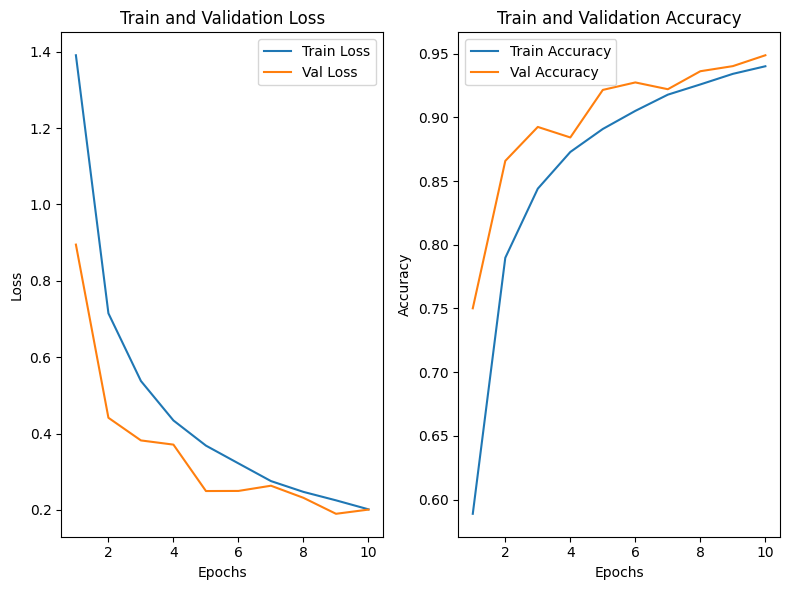

In [14]:
from tqdm import tqdm

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    model.train()
    running_train_loss = 0.0
    running_val_loss = 0.0
    correct_train = 0
    total_train = 0
    correct_val = 0
    total_val = 0

    for images, labels in tqdm(train_loader, desc = "Training", leave = True):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    model.eval()
    with torch.no_grad():
        for images, labels in tqdm(valid_loader, desc = "Validating", leave = True):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    epoch_train_loss = running_train_loss / len(train_loader)
    epoch_val_loss = running_val_loss / len(valid_loader)
    train_losses.append(epoch_train_loss)
    valid_losses.append(epoch_val_loss)

    epoch_train_acc = correct_train / total_train
    epoch_val_acc = correct_val / total_val
    train_acc.append(epoch_train_acc)
    valid_acc.append(epoch_val_acc)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}, Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}')

    if epoch_val_loss < best_valid_loss:
        best_valid_loss = epoch_val_loss
        torch.save(model.state_dict(), 'best_DN121_model_FT.pth')
        print(f"Model weights saved for epoch {epoch + 1} with validation loss: {best_valid_loss:.4f}")

    # Clear CUDA cache
    torch.cuda.empty_cache()

print(f"Batch size: {BATCH_SIZE}, Learning rate: {lr}, Number of epochs: {num_epochs}")
print(f"Best training accuracy: {max(train_acc):.2f}%")
print(f"Best validation accuracy: {max(valid_acc):.2f}%")
print("Plots for current hyperparameter combination:")
epochs_range = range(1, num_epochs + 1)
plt.figure(figsize=(8, 6))
# Plot loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, valid_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_acc, label='Train Accuracy')
plt.plot(epochs_range, valid_acc, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()
plt.tight_layout()
plt.show()


### Evaluating model on test set

In [ ]:
model = models.densenet121(pretrained=True)
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, 25)
# Load the model weights
#model_weights_path = 'best_model.pth'
#model.load_state_dict(torch.load(model_weights_path))
model.to(device)


# Evaluate model on test set :-

import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve

model.eval()
test_accuracy = 0
all_labels = []
all_predictions = []
all_probabilities = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        test_accuracy += (predicted == labels).sum().item()
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())
        all_probabilities.extend(F.softmax(outputs, dim=1).cpu().numpy())


test_accuracy = test_accuracy / len(test_dataset)
print(f'Test Accuracy: {test_accuracy:.4f}')


# Calculate precision, recall, and F1-score
precision = precision_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')
f1 = f1_score(all_labels, all_predictions, average='weighted')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')

# Calculate ROC AUC score
roc_auc = roc_auc_score(all_labels, all_probabilities, multi_class='ovr')
print(f'ROC AUC Score: {roc_auc:.4f}')

"""
# Calculate Consfusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)
print("Confusion Matrix:")
print(conf_matrix)

# Plot Confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=lb.classes_, yticklabels=lb.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Plot ROC - AUC curve :-
fpr, tpr, _ = roc_curve(all_labels, all_probabilities, multi_class='ovr')
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
"""
